In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm

import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import ast
import yaml
from scipy.ndimage import zoom
from matplotlib.patches import Patch
%matplotlib inline

In [2]:
def load_parameters(directory):
    """Load the parameters yaml file containing all the parameters required for
    preprocessing MAPseq data

    Args:
    directory (str): Directory where to load parameters from. Default 'root' for the
        default parameters (found in `mapseq_preprocessing/parameters.py`).

    Returns:
        dict: contents of parameters.yml
    """

    def flatten_dict(d):
        flattened_dict = {}
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened_dict[subkey] = subvalue
            else:
                flattened_dict[key] = value
        return flattened_dict

    if directory == "root":
        parameters_file = pathlib.Path(__file__).parent / "parameters.yml"
    else:
        parameters_file = pathlib.Path(directory) / "parameters.yml"
    with open(parameters_file, "r") as f:
        parameters = flatten_dict(yaml.safe_load(f))
    return parameters



In [3]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]


In [4]:
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)


bf_left_boundaries = bf_boundary_finder.region_boundaries()

bf_right_boundaries = bf_boundary_finder.region_boundaries(
    hemisphere="right_for_both",
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    convert_to_flat_path / "flatmap_butterfly.h5",
    convert_to_flat_path / "surface_paths_10_v3.h5",
    hemisphere="both",
    view_space_for_other_hemisphere="flatmap_butterfly",
)

loading path information


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1016/1016 [00:05<00:00, 174.91it/s]


In [5]:
#combine the two mice
#combined_samples = (roi_dict['FIAA45.6a'] > 0) | (roi_dict['FIAA45.6d'] > 0).astype(int) #| (roi_dict['FIAA55.4d'])).astype(int)
combined_samples = ((roi_dict['FIAA45.6a'] > 0) | (roi_dict['FIAA45.6d'] > 0) | (roi_dict['FIAA55.4d'] > 0)).astype(int)

vis_barcodes = {}
for mouse in mice:
    VIS_samples = sample_vol_and_regions[mouse][sample_vol_and_regions[mouse].main.str.contains('VIS')]['ROI Number'].to_list()
    VIS_samples = [sample for sample in VIS_samples if sample in barcodes_dict[mouse].columns]
    barcodes_across_sample =barcodes_dict[mouse]
    vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]


a = ['FIAA45.6a' for _ in range(len(vis_barcodes['FIAA45.6a']))]
d = ['FIAA45.6d' for _ in range(len(vis_barcodes['FIAA45.6d']))]
d2 = ['FIAA55.4d' for _ in range(len(vis_barcodes['FIAA55.4d']))]
a.extend(d)

a.extend(d2)
combined_barcodes_mouse = pd.DataFrame({'mouse': a})
#combined_all_barcodes= pd.concat([vis_barcodes['FIAA45.6a'], vis_barcodes['FIAA45.6d']])


/tmp/ipykernel_681509/266062619.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]
/tmp/ipykernel_681509/266062619.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]
/tmp/ipykernel_681509/266062619.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]


In [106]:
# dorsal_ind = 1965
# all_ind = 309
# ventral_ind = 152
# SSp_regions = []
# # # SSp_all_coords ={}
# # for key in bf_left_boundaries.keys():
# #     if 'SSp' in key:
# #         SSp_regions.append(str(key))
# #         # coords = bf_left_boundaries[key]
# #         # SSp_all_coords[key] = coords
# # new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
# # new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    


# ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
# allen_anno = np.array(ref_anno)
# annotation = allen_anno[0]
# #roi_projection_max = proj_top.project_volume(combined_samples)
# # Set up the figure with 7x4 subplots
# fig, axes = plt.subplots(3, 1, figsize=(6, 11))  # 7x4 grid of subplots
# axes = axes.ravel()  # Flatten to easily iterate through
# resolution = 25
# # Loop to create each plot
# for idx, barcode_index in enumerate([dorsal_ind, all_ind, ventral_ind]):
#     # Randomly select a barcode index
#     mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
#     if mouse=='FIAA45.6d':
#         adjusted_bc_ind = barcode_index-len(vis_barcodes['FIAA45.6a']+1)
#     elif mouse == 'FIAA55.4d':
#         adjusted_bc_ind = barcode_index-(len(vis_barcodes['FIAA45.6a']) + len(vis_barcodes['FIAA45.6d'])+1)
#     elif mouse == 'FIAA45.6a':
#         adjusted_bc_ind = barcode_index
#     barcodes_across_sample = vis_barcodes[mouse]
#     roi_to_look = roi_dict[mouse]
#     mask = np.isin(roi_to_look, barcodes_across_sample.columns) #only keep samples that haven't been filtered out 
#     roi_to_look = np.where(mask, roi_to_look, 0)
#     all_flatmap = proj_top.project_volume(roi_to_look)
#     #rebuilding_all_flatmap = np.zeros_like(all_flatmap)  #make a dummy flatmap filled with -1
#     rebuilding_all_flatmap = np.where(all_flatmap == 0, -1, 0)
#     for roi in barcodes_across_sample.columns:
#         if barcodes_across_sample.iloc[adjusted_bc_ind][roi] > 0:
#             binary_roi_array = np.where(roi_to_look == roi, barcodes_across_sample.iloc[adjusted_bc_ind][roi], 0)
#             flat_projection = proj_top.project_volume(binary_roi_array)
#             rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]

    
#     # # Convert to 10um resolution
#     # barcode_3D = zoom(empty_frame, zoom=zoom_factors, order=0)
#     # barcode_projection_max = proj_top.project_volume(barcode_3D)

#     max_value = np.max(rebuilding_all_flatmap)
#     only_projections = np.where(rebuilding_all_flatmap == max_value, 0, rebuilding_all_flatmap)
#     only_source = np.where(rebuilding_all_flatmap == max_value, 1, 0)
#     vmax_value = np.max(only_projections)
#     # Get the current subplot
#     ax = axes[idx]

#     # Plot on the current axis
#     cmap_background = mcolors.ListedColormap(['dimgrey', 'black'])
#     #ax.imshow(roi_projection_max.T, cmap=cmap_background)
#     masked_new_mat = np.ma.masked_where(only_projections <= 0, only_projections)
#     new_fig = ax.imshow(masked_new_mat.T, cmap='plasma', norm=LogNorm())#vmax=vmax_value)
#     masked_source_mat = np.ma.masked_where(only_source <= 0, only_source)
#     ax.imshow(masked_source_mat.T, cmap='Set1')
#     ax.axis('off')
#     ax.set_title(f"Neuron {barcode_index}", fontsize=16)

#     cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
#     cbar.set_label("Normalised counts/µm³", fontsize=14)
#     cbar.ax.tick_params(labelsize=14)
#     # Add boundaries
#     for k, boundary_coords in new_left_bound_dict.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.6)
#     for k, boundary_coords in new_right_bound_dict.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.6)

# # Adjust layout and show the figure
# plt.tight_layout()
# plt.show()

In [ ]:
#lets make a histogram showing the projections


In [6]:
def normalize_barcodes(barcodes):
    # Copy to ensure original data isn't altered
    normalized_barcodes = barcodes.copy().astype(float)
    for index, row in normalized_barcodes.iterrows():
        max_val = row.max()  # Find the maximum value
        # Exclude the maximum value from normalization
        other_values_sum = row.sum() - max_val
        if other_values_sum > 0:  # Avoid division by zero
            normalized_barcodes.loc[index] = row / other_values_sum
        normalized_barcodes.loc[index][row.idxmax()] = 1.0  # Set max value to 1
    return normalized_barcodes

In [7]:
def homog_across_cubelet(
    parameters_path,
    cortical,
    shuffled,
    barcode_matrix,
    CT_PT_only=False,
    IT_only=False,
    area_threshold=0.1, binary =False,
):
    """
    Function to output a matrix of homogenous across areas, looking only at cortical samples
    Args:
        parameters_path
        barcode_matrix = pandas dataframe with barcodes
        cortical (bool): True if you want onkly to look at cortical regions
        shuffled (bool): True if you want to shuffle values in all columns as a negative control
        CT_PT_only (bool): True if you just want to look at corticothalamic/pyramidal tract neurons
        IT_only (bool): True if you want to look at only intratelencephalic neurons
    """
    parameters = load_parameters(directory=parameters_path)
    sequencing_directory = pathlib.Path(
        "".join(
            [
                parameters["PROCESSED_DIR"],
                "/",
                parameters["PROJECT"],
                "/",
                parameters["MOUSE"],
                "/Sequencing",
            ]
        )
    )

    # barcodes_across_sample = pd.read_pickle(sequencing_directory / "A1_barcodes.pkl")
    barcodes_across_sample = barcode_matrix.copy()

    lcm_directory = parameters["lcm_directory"]
    cortical_samples_columns = [
        int(col)
        for col in parameters["cortical_samples"]
        if col in barcodes_across_sample.columns
    ]
    # only look at cortical samples
    if cortical:
        barcodes_across_sample = barcodes_across_sample[cortical_samples_columns]
    if CT_PT_only or IT_only:
        sample_vol_and_regions = pd.read_pickle(
            "".join([lcm_directory, "/sample_vol_and_regions.pkl"])
        )
        sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
            ast.literal_eval
        )
        roi_list = []
        index_list = []
        for index, row in sample_vol_and_regions.iterrows():
            if any(
                "IC" in region
                or "SCs" in region
                or "SCm" in region
                or "LGd" in region
                or "LGv" in region
                or "MGv" in region
                or "RT" in region
                or "LP" in region
                or "MGd" in region
                or "P," in region
                for region in row["regions"]
            ):
                if row["ROI Number"] not in parameters["cortical_samples"]:
                    index_list.append(index)
                    roi_list.append(row["ROI Number"])
        roi_list = [
            sample for sample in roi_list if sample in barcodes_across_sample.columns
        ]
        if CT_PT_only:
            barcodes_across_sample = barcodes_across_sample[
                barcodes_across_sample[roi_list].sum(axis=1) > 0
            ]
        if IT_only:
            barcodes_across_sample = barcodes_across_sample[
                barcodes_across_sample[roi_list].sum(axis=1) == 0
            ]
    barcodes_across_sample = barcodes_across_sample[
        barcodes_across_sample.astype(bool).sum(axis=1) > 0
    ]

    areas_only_grouped = get_area_volumes(
        barcode_table_cols=barcodes_across_sample.columns,
        lcm_directory=lcm_directory,
        area_threshold=area_threshold,
    )
    zero_cols = areas_only_grouped.index[
        (areas_only_grouped == 0).all(axis=1, skipna=True)
    ].tolist()  # added as i've increased the threshold for testing
    areas_only_grouped.drop(zero_cols, inplace=True)
    barcodes_across_sample.drop(columns=zero_cols, inplace=True)
    areas_matrix = areas_only_grouped.to_numpy()
    total_frac = np.sum(areas_matrix, axis=1)
    frac_matrix = areas_matrix / total_frac[:, np.newaxis]
    weighted_frac_matrix = frac_matrix / areas_matrix.sum(axis=0)
    # barcodes_sum = barcodes_across_sample.sum(axis=1)
    # barcodes_across_sample =barcodes_across_sample.div(barcodes_sum, axis=0)
    barcodes = barcodes_across_sample.to_numpy()
    if shuffled and not binary:
        barcodes = send_to_shuffle(barcodes=barcodes)
    if binary and shuffled:
        barcodes = send_for_curveball_shuff(barcodes = barcodes) 
    total_projection_strength = np.sum(barcodes, axis=1)  # changed as normalised before
    barcodes = barcodes / total_projection_strength[:, np.newaxis]
    bc_matrix = np.matmul(barcodes, weighted_frac_matrix)
    bc_matrix = pd.DataFrame(
        data=bc_matrix,
        columns=areas_only_grouped.columns.to_list(),
        index=barcodes_across_sample.index,
    )
    # bool_barcodes= barcodes_across_sample.astype(bool).astype(int).to_numpy()
    # vol_matrix = np.matmul(bool_barcodes, areas_matrix)
    # bc_matrix = bc_matrix/vol_matrix
    bc_matrix = bc_matrix.dropna(axis=1, how="all")
    bc_matrix = bc_matrix.loc[~(bc_matrix == 0).all(axis=1)]
    # bc_matrix =bc_matrix.reset_index(drop=True)
    if binary:
        bc_matrix = bc_matrix.astype(bool).astype(int)
    return bc_matrix.fillna(0)
def get_area_volumes(barcode_table_cols, lcm_directory, area_threshold=0.1):
    """
    Function to get volumes of each registered brain area from each LCM sample
    Args:
        barcode_table_cols: list of column names of the barcode matrix
        lcm_directory: path to where the lcm_directory is
        area_threshold (int): minimum value that defines a brain area within a cubelet
    Returns: area vol pandas dataframe
    """
    sample_vol_and_regions = pd.read_pickle(
        "".join([lcm_directory, "/sample_vol_and_regions.pkl"])
    )
    sample_vol_and_regions = sample_vol_and_regions[
        sample_vol_and_regions["ROI Number"].isin(barcode_table_cols)
    ]
    sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
        ast.literal_eval
    )
    sample_vol_and_regions["breakdown"] = sample_vol_and_regions["breakdown"].apply(
        ast.literal_eval
    )
    all_areas_unique_acronymn = np.unique(
        sample_vol_and_regions["regions"].explode().to_list()
    )
    all_area_df = pd.DataFrame(
        index=barcode_table_cols, columns=all_areas_unique_acronymn
    )
    for column in barcode_table_cols:
        # all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
        index = sample_vol_and_regions[
            sample_vol_and_regions["ROI Number"] == column
        ].index
        reg = pd.DataFrame()
        reg["regions"] = [i for i in sample_vol_and_regions.loc[index, "regions"]][0]
        reg["fraction"] = [i for i in sample_vol_and_regions.loc[index, "breakdown"]][0]
        reg["vol_area"] = (
            reg["fraction"] * sample_vol_and_regions.loc[index, "Volume (um^3)"].item()
        )

        for _, row in reg.iterrows():
            all_area_df.loc[column, row["regions"]] = row["vol_area"]
    group_areas = {"Contra": all_area_df.filter(like="Contra").columns}
    areas_grouped = all_area_df.copy()
    for group, columns in group_areas.items():
        areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
        columns = [value for value in columns if value in all_area_df.columns]
        areas_grouped = areas_grouped.drop(columns, axis=1)
    nontarget_list = ["fiber tracts", "root"]
    nontarget_list = [value for value in nontarget_list if value in all_area_df.columns]
    areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)
    areas_only_grouped = areas_only_grouped.apply(
        lambda row: row.where(row >= area_threshold * row.sum(), np.nan), axis=1
    )
    areas_only_grouped = areas_only_grouped.fillna(0)
    areas_only_grouped = areas_only_grouped.loc[
        :, (areas_only_grouped != 0).any(axis=0)
    ]

    return areas_only_grouped


In [8]:
def convert_matrix_names(matrix):
    convert_dict = {
        "VISp": "V1",
        "VISpor": "POR",
        "VISli": "LI",
        "VISal": "AL",
        "VISl": "LM",
        "VISpl": "P",
        "VISpm": "PM",
        "VISrl": "RL",
        "VISam": "AM",
        "VISa": "A",
    }
    matrix.rename(columns=convert_dict, inplace=True)
    matrix.rename(index=convert_dict, inplace=True)
    return matrix

In [9]:
combined_dict = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    combined_dict[mouse]=homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, binary=False, cortical=True, IT_only=True, shuffled=False)

In [10]:
convert_dict = {
        "VISp": "V1",
        "VISpor": "POR",
        "VISli": "LI",
        "VISal": "AL",
        "VISl": "LM",
        "VISpl": "P",
        "VISpm": "PM",
        "VISrl": "RL",
        "VISam": "AM",
        "VISa": "A",
    }
common_columns_cubelet = set(combined_dict[mice[0]].columns)
for mouse in mice[1:]:
    common_columns_cubelet = common_columns_cubelet.intersection(
        combined_dict[mouse].columns
    )

common_columns_cubelet = list(common_columns_cubelet)
all_cols_renamed = [
    convert_dict[s] if s in convert_dict
    else s
    for s in common_columns_cubelet
]
def find_non_overlapping_position(ax, x, y, label, placed_texts, renderer, jitter_range=10, max_tries=50):
    for _ in range(max_tries):
        collision = False
        test_text = ax.text(x, y, label, color="white", fontsize=8, ha='center', va='center', alpha=0)  # Invisible text for testing
        bb_new = test_text.get_window_extent(renderer=renderer)

        for existing_text in placed_texts:
            bb_existing = existing_text.get_window_extent(renderer=renderer)
            if bb_existing.overlaps(bb_new):
                collision = True
                break

        test_text.remove()  # Remove test text
        if not collision:
            return x, y
        else:
            # Apply jitter to avoid overlap
            x += np.random.uniform(-jitter_range, jitter_range)
            y += np.random.uniform(-jitter_range, jitter_range)

    return x, y  # Return the best position found (may still overlap if max_tries is exceeded)



In [ ]:

gen_ind = 1965
all_ind = 309
dorsal_ind = 205
ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

fig, axes = plt.subplots(1, 4, figsize=(28, 9), gridspec_kw={"width_ratios": [0.6, 1, 1, 1]} )

ax0 = axes[0]

ax0 = axes[0]

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color='white')

bl = np.full((2352, 1360), np.nan)
new_dict = {}
ssps_coords = []
convert_dict = {
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISal": "AL",
    "VISl": "LM",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISa": "A",
}

for key, coords in bf_right_boundaries.items():
    if key.startswith('SSp'):
        ssps_coords.append(coords)
    else:
        new_dict[key] = coords
    if key in convert_dict:
        to_name = convert_dict[key]
        new_dict[to_name] = coords

if ssps_coords:
    combined_ssp = np.concatenate(ssps_coords, axis=0)
    new_dict['SSp'] = combined_ssp

half_col = bl.shape[0] // 2
bl_right = bl[half_col:, :]
im = ax0.imshow(bl_right.T, cmap=cmap)

placed_texts = []
plt.gcf().canvas.draw()
renderer = plt.gcf().canvas.get_renderer()


for k, boundary_coords in new_dict.items():
    mask = boundary_coords[:, 0] >= half_col
    if not np.any(mask):
        continue
    shifted_coords = boundary_coords[mask].copy()
    shifted_coords[:, 0] -= half_col

    if k != 'SSp':
        ax0.plot(*shifted_coords.T, c="black", lw=0.6)

    centroid_x = np.mean(shifted_coords[:, 0])
    centroid_y = np.mean(shifted_coords[:, 1])
    # all_cols_renamed presumably is your set of region names
    # if you only want certain labels, use a condition:
    if k in all_cols_renamed:
        x, y = centroid_x, centroid_y
        text_obj = ax0.text(x, y, k, color="orchid", fontsize=8, ha='center', va='center')
        placed_texts.append(text_obj)

ax0.axis("off")

resolution = 25

barcode_indices = [dorsal_ind, all_ind, gen_ind]
for idx, barcode_index in enumerate(barcode_indices):
    ax = axes[idx + 1]  # use columns 1, 2, 3 in the row
    
    mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
    if mouse=='FIAA45.6d':
        adjusted_bc_ind = barcode_index - len(vis_barcodes['FIAA45.6a']+1)
    elif mouse == 'FIAA55.4d':
        adjusted_bc_ind = barcode_index - (len(vis_barcodes['FIAA45.6a'])
                                           + len(vis_barcodes['FIAA45.6d']) + 1)
    elif mouse == 'FIAA45.6a':
        adjusted_bc_ind = barcode_index

    barcodes_across_sample = vis_barcodes[mouse]
    roi_to_look = roi_dict[mouse]
    vals = np.unique(roi_to_look)
    values_not_in_barcodes = vals[~np.isin(vals, barcodes_across_sample.columns)]
    mask = ~np.isin(roi_to_look, values_not_in_barcodes)
    roi_to_look = np.where(mask, roi_to_look, 0)
    all_flatmap = proj_top.project_volume(roi_to_look)
    rebuilding_all_flatmap = np.where(all_flatmap == 0, -1.0, 0.0)
    #bc = normalize_barcodes(barcodes_across_sample)
    bc = barcodes_across_sample.copy()
    val_list = []
    for roi in bc.columns:
        if bc.iloc[adjusted_bc_ind][roi] > 0:
            # only proceed if in roi_to_look
            if roi in roi_to_look: #since we filtered for cortical samples only
                val = bc.iloc[adjusted_bc_ind][roi]
                count = np.sum(roi_to_look == roi)
                # vol = count/(10**3)
                # density = val/vol
                val_list.append(val)
                binary_roi_array = np.where(roi_to_look == roi, val, 0.0)
                flat_projection = proj_top.project_volume(binary_roi_array)
                rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]
    smallest_value = (min(val_list)) * 0.1
    no_val_vals = (rebuilding_all_flatmap == -1)
    rebuilding_all_flatmap[no_val_vals] = -smallest_value
    change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)
    change_me = np.flip(change_me, axis=1)  # flip orientation
    finite_vals = change_me[np.isfinite(change_me)]
    max_value = np.max(finite_vals)
    second_max_value = np.max(finite_vals[finite_vals < max_value]) if np.any(finite_vals < max_value) else max_value
    # second_max_value = np.max(finite_vals[finite_vals < max_value]) \
    #     if np.any(finite_vals < max_value) else max_value
    vmin = np.min(finite_vals)
    vmax = second_max_value
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    base_cmap = plt.cm.magma
    new_cmap = base_cmap.copy()
    new_cmap.set_over('chartreuse')
    new_cmap.set_bad(color='grey')
    masked_data = np.ma.masked_invalid(change_me)
    im_map = ax.imshow(masked_data, cmap=new_cmap, norm=norm, interpolation='nearest')

    
    #im_map = ax.imshow(all_flatmap.T, cmap=new_cmap, interpolation='nearest')
    ax.set_title(f"Neuron {barcode_index}", fontsize=12)
    ax.axis('off')
    
    cbar = fig.colorbar(im_map, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Log10(counts)", fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)

    ax_inset = ax.inset_axes([1.41, -0.2, 0.1, 1.5])  # adjust location/size as needed

    parameters_path = f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/"
    AUD_source = sample_vol_and_regions[mouse][
        sample_vol_and_regions[mouse].main.str.contains('AUDp')]['ROI Number'].to_list()
    AUD_source = [s for s in AUD_source if s in barcodes_across_sample.columns]

    barcodes_across_sample_source_dropped = barcodes_across_sample.drop(columns=AUD_source)
    bc_across_area = homog_across_cubelet(
        parameters_path=parameters_path,
        barcode_matrix=barcodes_across_sample_source_dropped,
        cortical=True,
        shuffled=False,
        binary=False,
        IT_only=True,
        area_threshold=0.1
    )
    
    # Drop any non-cortical or undesired columns
    to_drop = ['AUDp', 'STR', 'HPF']
    to_drop = [b for b in to_drop if b in bc_across_area.columns]
    bc_across_area = bc_across_area.drop(columns=to_drop)
    bc_across_area = convert_matrix_names(bc_across_area)

    labels = bc_across_area.iloc[adjusted_bc_ind].index.astype(str).tolist()
    values = bc_across_area.iloc[adjusted_bc_ind].values
    y_positions = np.arange(len(labels))

    ax_inset.barh(y_positions, values, color='orchid', edgecolor='black')
    ax_inset.set_yticks(y_positions)
    ax_inset.set_yticklabels(labels)
    ax_inset.invert_yaxis()  # optional if you like top-down

    #if idx == 0:
    ax_inset.set_xlabel("Projection strength", fontsize=8)
    ax_inset.xaxis.set_label_coords(0.5, -0.2)
    ax_inset.set_ylabel("")


chartreuse_patch = Patch(facecolor='chartreuse', edgecolor='none', label='Soma cubelet')
fig.legend(
    handles=[chartreuse_patch],
    loc='upper right',
    fontsize=8,
    bbox_to_anchor=(0.98, 0.75),  # Move it down from the very top
    bbox_transform=fig.transFigure
)
plt.subplots_adjust(wspace=0.6) 
pos0 = ax0.get_position()   # [x0, y0, width, height] in figure coords
new_x0 = pos0.x0 + 0.07
new_width = pos0.width + 0

ax0.set_position([new_x0, pos0.y0, new_width, pos0.height])
#plt.tight_layout()
plt.show()


/tmp/ipykernel_679126/698993638.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)
/tmp/ipykernel_679126/698993638.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


/tmp/ipykernel_3973529/3166761196.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


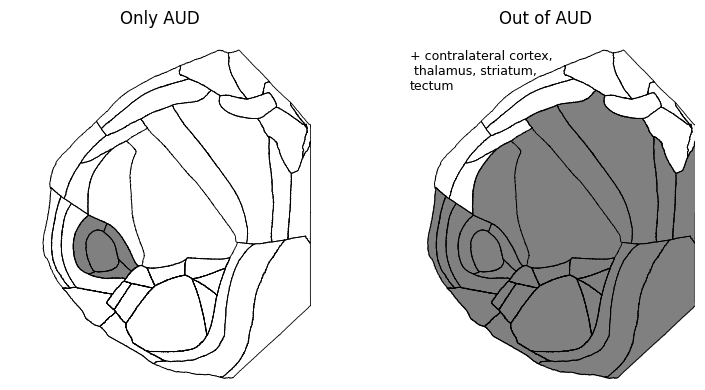

In [48]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color='white')

# Create a blank image (flatmap) with NaNs.
bl = np.full((2352, 1360), np.nan)

# Process boundaries
new_dict = {}
ssps_coords = []
convert_dict = {
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISal": "AL",
    "VISl": "LM",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISa": "A",
}

for key, coords in bf_left_boundaries.items():
    if key.startswith('SSp'):
        ssps_coords.append(coords)
    else:
        new_dict[key] = coords
    if key in convert_dict:
        new_dict[convert_dict[key]] = coords

if ssps_coords:
    combined_ssp = np.concatenate(ssps_coords, axis=0)
    new_dict['SSp'] = combined_ssp

# We'll display the left half of the flatmap.
half_col = bl.shape[0] // 2
bl_left = bl[half_col:, :]

# Define two conditions:
# Left panel: fill if key contains "AUD"
# Right panel: fill if key contains "SSp"
conditions = [
    (lambda k: 'AUD' in k, 'Only AUD'),
    (lambda k: k in all_cols_renamed, 'Out of AUD')
]

# Loop over each subplot
for ax, (cond, title) in zip(axs, conditions):
    im = ax.imshow(bl_left.T, cmap=cmap)
    
    # Draw all boundaries (using left half coordinates)
    for k, boundary_coords in new_dict.items():
        # Select points with x-coordinate less than half_col.
        
        if k == 'SSp':
            if cond(k):
                mask = boundary_coords[:, 0] < half_col
                left_coords = boundary_coords[mask].copy()
                x, y = left_coords[:, 0], left_coords[:, 1]
                ax.fill(x, y, color='gray')
            continue
        mask = boundary_coords[:, 0] < half_col
        if not np.any(mask):
            continue
        # Use the unshifted coordinates (for left side)
        left_coords = boundary_coords[mask].copy()
        # Draw the boundary outline in black.
        ax.plot(*left_coords.T, c="black", lw=0.6)
        
        # If the condition is met, fill the polygon.
        if cond(k):
            # Fill using the boundary points; adjust color if needed.
            x, y = left_coords[:, 0], left_coords[:, 1]
            ax.fill(x, y, color='gray')
    if title == 'Out of AUD':
        ax.text(0.05, 0.95, f'+ contralateral cortex,\n thalamus, striatum, \ntectum',
                transform=ax.transAxes, fontsize=9, color='black', 
                verticalalignment='top')
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_3973529/2370121709.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


(-0.5, 1175.5, 1359.5, -0.5)

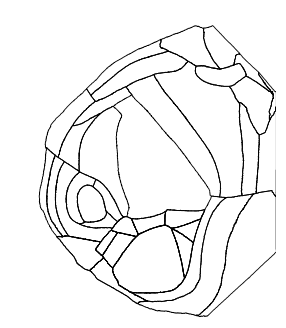

In [35]:
fig, ax = plt.subplots(1, figsize=(4, 4))
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color='white')  
bl = np.full((2352, 1360), np.nan)
new_dict = {}
ssps_coords = []
convert_dict = {
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISal": "AL",
    "VISl": "LM",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISa": "A",
}

# Process boundaries
for key, coords in bf_left_boundaries.items():
    if key.startswith('SSp'):
        ssps_coords.append(coords)
    else:
        new_dict[key] = coords
    if key in convert_dict:
        to_name = convert_dict[key]
        new_dict[to_name] = coords

if ssps_coords:
    combined_ssp = np.concatenate(ssps_coords, axis=0)
    new_dict['SSp'] = combined_ssp

# Display the right half of the flatmap
half_col = bl.shape[0] // 2
bl_left = bl[half_col:, :]
im = ax.imshow(bl_left.T, cmap=cmap)
placed_texts = []

plt.gcf().canvas.draw()
renderer = plt.gcf().canvas.get_renderer()

for k, boundary_coords in new_dict.items():
    mask = boundary_coords[:, 0] < half_col
    if not np.any(mask):
        continue
    # For left side, do not shift the coordinates:
    left_coords = boundary_coords[mask].copy()
    if k != 'SSp':
        ax.plot(*left_coords.T, c="black", lw=0.6)
    centroid_x = np.mean(left_coords[:, 0])
    centroid_y = np.mean(left_coords[:, 1])

    # if k in all_cols_renamed:
    #     x, y = centroid_x, centroid_y
    #     text_obj = ax.text(x, y, k, color="orchid", fontsize=8, ha='center', va='center')
    #     placed_texts.append(text_obj)
ax.axis("off")

/tmp/ipykernel_622508/1437596253.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


done this part


/tmp/ipykernel_622508/1437596253.py:79: RuntimeWarning: divide by zero encountered in log10
  change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)


done this part


/tmp/ipykernel_622508/1437596253.py:79: RuntimeWarning: divide by zero encountered in log10
  change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)


done this part


/tmp/ipykernel_622508/1437596253.py:79: RuntimeWarning: divide by zero encountered in log10
  change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)


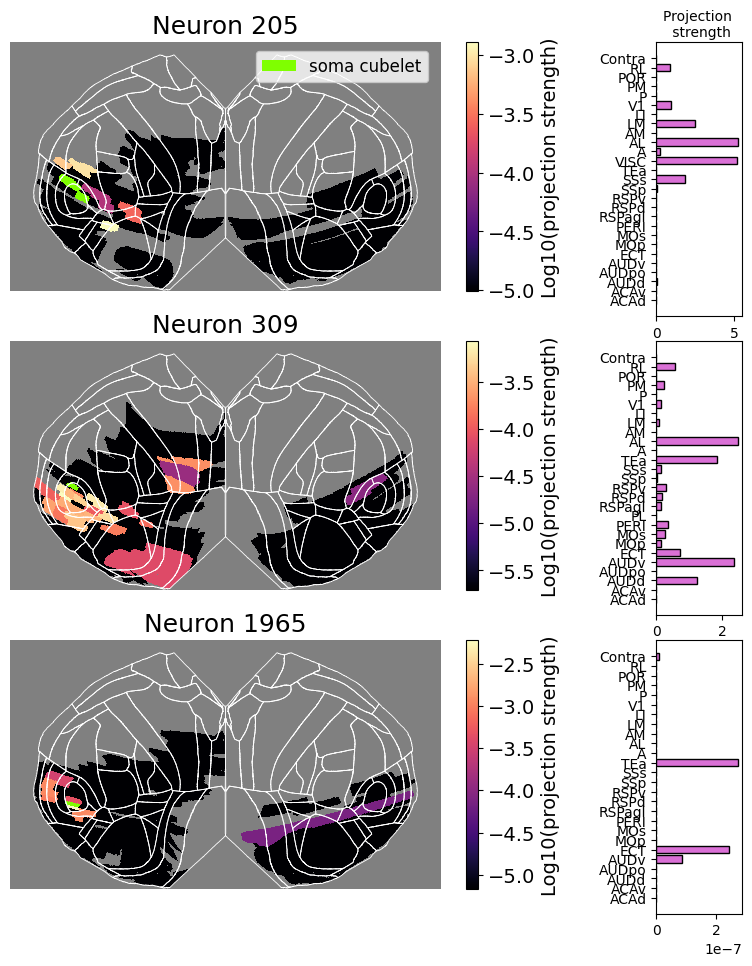

In [13]:
gen_ind = 1965
all_ind = 309
dorsal_ind = 205#152
#SSp_regions = []
# # SSp_all_coords ={}
# for key in bf_left_boundaries.keys():
#     if 'SSp' in key:
#         SSp_regions.append(str(key))
#         # coords = bf_left_boundaries[key]
#         # SSp_all_coords[key] = coords
# new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
# new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    


ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]
#roi_projection_max = proj_top.project_volume(combined_samples)
# Set up the figure with 7x4 subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 11))  # 7x4 grid of subplots
vertical_positions = [0.85, 0.55, 0.25]  # Adjust these values for even spacing
plot_height = 0.25  # Height of each subplot (proportional)
axes = axes.ravel()  # Flatten to easily iterate through
resolution = 25
# Loop to create each plot
for idx, barcode_index in enumerate([dorsal_ind, all_ind, gen_ind]):
    # Randomly select a barcode index
    mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
    if mouse=='FIAA45.6d':
        adjusted_bc_ind = barcode_index-len(vis_barcodes['FIAA45.6a']+1)
    elif mouse == 'FIAA55.4d':
        adjusted_bc_ind = barcode_index-(len(vis_barcodes['FIAA45.6a']) + len(vis_barcodes['FIAA45.6d'])+1)
    elif mouse == 'FIAA45.6a':
        adjusted_bc_ind = barcode_index
    barcodes_across_sample = vis_barcodes[mouse]
    #barcodes_across_sample = barcodes_across_sample.div(barcodes_across_sample.sum(axis=1), axis=0) #normalise barcodes to 1
    roi_to_look = roi_dict[mouse]
    vals = np.unique(roi_to_look)
    values_not_in_barcodes = vals[~np.isin(vals, barcodes_across_sample.columns)]
    mask = ~np.isin(roi_to_look, values_not_in_barcodes)
    #mask = np.isin(roi_to_look, barcodes_across_sample.columns) #only keep samples that haven't been filtered out 
    roi_to_look = np.where(mask, roi_to_look, 0)
    all_flatmap = proj_top.project_volume(roi_to_look)
    #rebuilding_all_flatmap = np.zeros_like(all_flatmap)  #make a dummy flatmap filled with -1
    rebuilding_all_flatmap = np.where(all_flatmap == 0, -1.0, 0.0)
    bc = normalize_barcodes(barcodes_across_sample)
    #bc = barcodes_across_sample
    val_list = []
    for roi in bc.columns:
        if bc.iloc[adjusted_bc_ind][roi] > 0:
            if roi in roi_to_look: #since we filtered for cortical samples only
                val = bc.iloc[adjusted_bc_ind][roi]
                count = np.sum(roi_to_look == roi)
                vol = count/(10**3)
                density = val/vol
                val_list.append(density)  
            # binary_roi_array = np.where(roi_to_look == roi, density, 0)
                binary_roi_array = np.array(
    np.where(roi_to_look == roi, density, 0.0),
)
                flat_projection = proj_top.project_volume(binary_roi_array)
                rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]

    print('done this part', flush=True)
    smallest_value = (min(val_list))*0.1
    no_val_vals = (rebuilding_all_flatmap == -1)
    rebuilding_all_flatmap[no_val_vals] = -smallest_value
    change_me = rebuilding_all_flatmap.T
    # change_me = np.log10(change_me+1)
    # max_val_idx = np.unravel_index(np.argmax(change_me, axis=None), change_me.shape)
    # #max_value = np.max(rebuilding_all_flatmap)
    # highlighted_array = np.zeros_like(change_me)
    # highlighted_array[max_val_idx] = 1
    # plasma_cmap = plt.cm.magma
    # new_colors = plasma_cmap(np.linspace(0, 1, 256))
    # green = np.array([0, 1, 0, 1])  # RGBA for green
    # new_cmap = ListedColormap(np.vstack((new_colors, green)))
    # new_cmap.set_bad(color=[0.3, 0.3, 0.3, 1]) 
    change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)
    change_me = np.flip(change_me, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
    # Exclude infinities when finding second_max_value, but keep them in the data
    finite_vals = change_me[np.isfinite(change_me)]
    max_value = np.max(finite_vals)
    second_max_value = np.max(finite_vals[finite_vals < max_value]) if np.any(finite_vals < max_value) else max_value
    vmin = np.min(finite_vals)
    vmax = second_max_value  
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    base_cmap = plt.cm.magma
    new_cmap = base_cmap.copy()
    new_cmap.set_over('chartreuse') 
    new_cmap.set_bad(color='grey')
    masked_data = np.ma.masked_invalid(change_me)
    ax = axes[idx]
    ax.set_position([0.1, vertical_positions[idx], 0.6, plot_height])
    # box = ax.get_position() 
    # #new_box = [box.x0, box.y0, box.width * 1.5, box.height* 1.5]
    # new_box = [box.x0, box.y0 + 0.05, box.width * 1.5, box.height * 1.3]
    ax.set_title(f"Neuron {barcode_index}", fontsize=18, y=1)
    #ax.set_position(new_box)
    new_fig = ax.imshow(
    masked_data,
    cmap=new_cmap,
    norm=norm,
    interpolation='nearest'
)
    ax.axis('off')

    cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Log10(projection strength)", fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    # Add boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
    ax_inset = ax.inset_axes([1.5, -0.1, 0.2, 1.1])
    barcodes_across_sample = vis_barcodes[mouse]
    parameters_path = f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/"
    AUD_source= sample_vol_and_regions[mouse][sample_vol_and_regions[mouse].main.str.contains('AUDp')]['ROI Number'].to_list()
    AUD_source = [s for s in AUD_source if s in barcodes_across_sample.columns]
    barcodes_across_sample_source_dropped = barcodes_across_sample.drop(columns=AUD_source)
    bc_across_area = homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_across_sample_source_dropped, cortical=True, shuffled=False, binary=False, IT_only=True, area_threshold=0.1)
    to_drop = ['AUDp', 'STR', 'HPF']
    to_drop = [b for b in to_drop if b in bc_across_area.columns]
    bc_across_area = bc_across_area.drop(columns=to_drop) #since we have already filtered out ROIs that aren't cortical or A1 source site, remove non-cortical ROIs from the bar-chart
    bc_across_area = convert_matrix_names(bc_across_area)
    labels = bc_across_area.iloc[adjusted_bc_ind].index.astype(str).tolist()
    values = bc_across_area.iloc[adjusted_bc_ind].values
    y_positions = np.arange(len(labels))
    ax_inset.barh(y_positions, values, color='orchid', edgecolor='black')
    #ax_inset.set_yticks([])
    ax_inset.set_ylabel("")  # remove label
    ax_inset.set_yticks(y_positions)
    ax_inset.set_yticklabels(labels)
    if idx == 0:  # Only for the first subplot
        ax_inset.set_xlabel("Projection \n strength")
        ax_inset.xaxis.set_label_position('top')  # Move the label to the top
        #ax.set_title(f"Neuron {barcode_index}", fontsize=18, y=1.1)
    else:
        ax_inset.set_xlabel("") 
        #ax.set_title(f"Neuron {barcode_index}", fontsize=18)
    #ax_inset.set_xlabel("Projection \n strength") 

    
chartreuse_patch = Patch(facecolor='chartreuse', edgecolor='none', label='soma cubelet')
fig.legend(handles=[chartreuse_patch], loc='upper right', fontsize=12, bbox_to_anchor=(0.84, 0.88))

plt.show()

In [31]:
area_groups = {
    "AUDITORY CORTEX": ["AUDd", "AUDv", "AUDpo"],
    "LATERAL CORTEX": ["TEa", "PERI", "ECT"], "VISUAL CORTEX": ["VISal", "VISp", "VISpl", "VISpm", "VISrl", "VISpor", "VISam", "VISl", "VISa", "VISli"],
    "SOMATOMOTOR CORTICAL AREAS": ["MOp", "MOs", "SSp", "SSs"], "CINGULATE CORTEX": ["RSPv", "RSPd", "RSPagl", "ACAd", "ACAv"]}

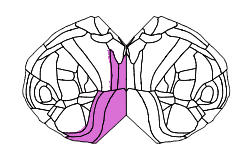

In [50]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
group = area_groups['CINGULATE CORTEX']
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False) #688 is id for whole  cortex
empty_frame = np.zeros((528, 320, 456))
x_midpoint = empty_frame.shape[2] // 2
structure_tree = mcc.get_structure_tree()
contra_mask = np.zeros(empty_frame.shape, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
inverse_contra_mask = np.zeros(empty_frame.shape, dtype=bool)
inverse_contra_mask[:, :, :x_midpoint] = 1
val = 1
colors = ["white", "orchid"]  # Background is white, val = 1 is green
n_bins = [1, 1]  # Discrete steps for each color
cmap_name = "custom_green"

# Create the colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=sum(n_bins))

# Normalize data to ensure values of 0 map to white and 1 to green
norm = mcolors.BoundaryNorm(boundaries=[0, 0.5, 1], ncolors=2)

for acronym in group:
    try:
        structure = structure_tree.get_structures_by_acronym([acronym])
    except KeyError:
        print(f'{acronym} does not exist - need to check naming')
    if 315 in structure[0]['structure_id_path']:
        structure_id = structure[0]['id']
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        mask_with_contra_mask = mask*contra_mask
        empty_frame[np.where(mask_with_contra_mask==1)] = val
    if acronym == 'Contra':
        structure_id = 315 #all isocortex
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        mask_with_inverse_contra_mask = mask*inverse_contra_mask
        empty_frame[np.where(mask_with_inverse_contra_mask==1)] = val

barcode_3D = zoom(empty_frame, zoom=zoom_factors, order=0)
projection_max = proj_top.project_volume(barcode_3D)
projection_max = np.flip(projection_max.T, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
plt.figure(figsize=(3, 2))
plt.imshow(projection_max, cmap=custom_cmap, norm=norm)
plt.axis('off')
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="black", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="black", lw=0.5)

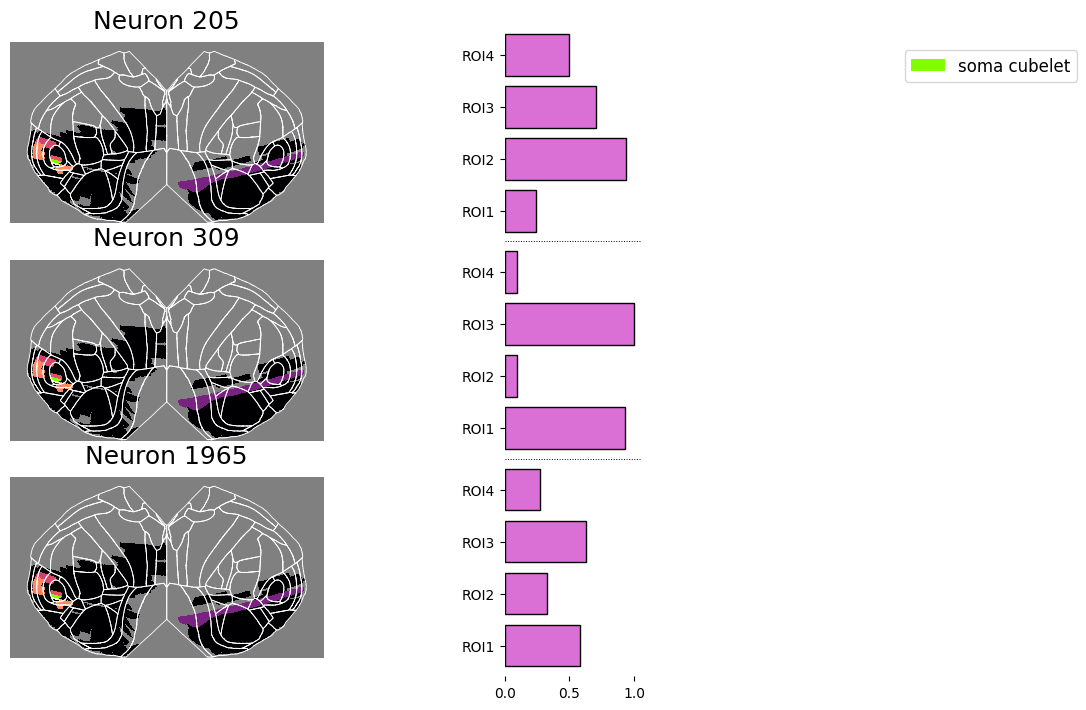

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Create a figure with 3 rows and 2 columns.
# Here we set width_ratios so the barplot column (right) gets more space.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 8),
                         gridspec_kw={'width_ratios': [0.4, 0.6]},
                         sharex='col')

ax_maps = axes[:, 0]   # Left column for flatmap images
ax_bars = axes[:, 1]   # Right column for horizontal barplots

# Loop over each neuron index
for idx, barcode_index in enumerate([dorsal_ind, all_ind, gen_ind]):
    # --- FLATMAP IMAGE (Left Column) ---
    ax_map = ax_maps[idx]
    # (Replace the following placeholder with your actual code)
    ax_map.imshow(masked_data, cmap=new_cmap, norm=norm, interpolation='nearest')
    ax_map.axis('off')
    ax_map.set_title(f"Neuron {barcode_index}", fontsize=18, pad=10)
    
    # Optionally add boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax_map.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax_map.plot(*boundary_coords.T, c="white", lw=0.6)
    
    # --- HORIZONTAL BARPLOT (Right Column) ---
    ax_bar = ax_bars[idx]
    # (Replace these placeholders with your data processing code)
    # For example, compute labels, values, and y_positions as needed.
    labels = ["ROI1", "ROI2", "ROI3", "ROI4"]
    values = np.random.rand(4)  # Example values; substitute with your actual data.
    y_positions = np.arange(len(labels))
    
    ax_bar.barh(y_positions, values, color='orchid', edgecolor='black')
    ax_bar.set_yticks(y_positions)
    ax_bar.set_yticklabels(labels, fontsize=10)
    # Remove any x-axis label (they share the same x-axis)
    ax_bar.set_xlabel("")
    # Remove spines for a cleaner look.
    for spine in ax_bar.spines.values():
        spine.set_visible(False)

# --- Adjust the Barplot Axes Sizes ---
# Increase the x-axis (width) and decrease the y-axis (height) for each barplot.
for ax_bar in ax_bars:
    pos = ax_bar.get_position()  # [x0, y0, width, height] in figure coordinates.
    new_height = pos.height * 1.2    # Shrink the vertical extent.
    new_width = pos.width * 0.2     # Increase the horizontal extent.
    new_y0 = pos.y0 + (pos.height - new_height) / 2  # Center vertically.
    new_x0 = pos.x0  # Keep the same left position.
    ax_bar.set_position([new_x0, new_y0, new_width, new_height])

# --- Add Dotted Lines Between Neuron Barplots ---
# Only draw a dotted line between the barplot subplots (i.e. between neurons).
for i in range(len(ax_bars) - 1):
    pos_top = ax_bars[i].get_position()
    pos_bottom = ax_bars[i+1].get_position()
    # Place the line halfway between the bottom of the top plot and the top of the bottom plot.
    y_line = (pos_top.y0 + pos_bottom.y1) / 2.0
    # Use the x-range of the barplot column.
    pos_col = ax_bars[0].get_position()
    x0, x1 = pos_col.x0, pos_col.x1
    fig.lines.append(plt.Line2D([x0, x1], [y_line, y_line],
                                color='black', linestyle=':', linewidth=0.7,
                                transform=fig.transFigure))

# Optionally add a legend patch if needed.
chartreuse_patch = Patch(facecolor='chartreuse', edgecolor='none', label='soma cubelet')
fig.legend(handles=[chartreuse_patch], loc='upper right', fontsize=12, bbox_to_anchor=(0.84, 0.88))

plt.show()


In [ ]:


# --- Define your indices and (optional) SSp filtering if needed ---
gen_ind = 1965
all_ind = 309
dorsal_ind = 205  # (originally 205 or 152)

# (Optional SSp filtering code omitted)

# --- Load annotation ---
ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

# --- Create a figure with 3 rows and 2 columns ---
# The left column (col0) will show the flatmap, and the right (col1) the barplot.
# We set width ratios so that the barplot column gets extra horizontal space.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 30),
                         gridspec_kw={'width_ratios': [0.6, 0.4]},
                         sharex='col')
ax_maps = axes[:, 0]  # Flatmap images
ax_bars = axes[:, 1]  # Horizontal barplots (sharing x-axis)

resolution = 25

# Loop over neurons
for idx, barcode_index in enumerate([dorsal_ind, all_ind, gen_ind]):
    # --- Determine mouse and adjust barcode index ---
    mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
    if mouse == 'FIAA45.6d':
        adjusted_bc_ind = barcode_index - (len(vis_barcodes['FIAA45.6a']) + 1)
    elif mouse == 'FIAA55.4d':
        adjusted_bc_ind = barcode_index - (len(vis_barcodes['FIAA45.6a']) + len(vis_barcodes['FIAA45.6d']) + 1)
    elif mouse == 'FIAA45.6a':
        adjusted_bc_ind = barcode_index

    # --- Process flatmap data ---
    barcodes_across_sample = vis_barcodes[mouse]
    roi_to_look = roi_dict[mouse]
    vals = np.unique(roi_to_look)
    values_not_in_barcodes = vals[~np.isin(vals, barcodes_across_sample.columns)]
    mask = ~np.isin(roi_to_look, values_not_in_barcodes)
    roi_to_look = np.where(mask, roi_to_look, 0)
    all_flatmap = proj_top.project_volume(roi_to_look)
    rebuilding_all_flatmap = np.where(all_flatmap == 0, -1.0, 0.0)
    bc = normalize_barcodes(barcodes_across_sample)

    val_list = []
    for roi in bc.columns:
        if bc.iloc[adjusted_bc_ind][roi] > 0:
            if roi in roi_to_look:  # only keep cortical samples
                val = bc.iloc[adjusted_bc_ind][roi]
                count = np.sum(roi_to_look == roi)
                vol = count / (10**3)
                density = val / vol
                val_list.append(density)
                binary_roi_array = np.where(roi_to_look == roi, density, 0.0)
                flat_projection = proj_top.project_volume(binary_roi_array)
                rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]

    print('done this part', flush=True)
    smallest_value = min(val_list) * 0.1
    no_val_vals = (rebuilding_all_flatmap == -1)
    rebuilding_all_flatmap[no_val_vals] = -smallest_value
    change_me = rebuilding_all_flatmap.T
    # Apply log transform and flip to correct orientation
    change_me = np.log10(rebuilding_all_flatmap.T + smallest_value)
    change_me = np.flip(change_me, axis=1)

    finite_vals = change_me[np.isfinite(change_me)]
    max_value = np.max(finite_vals)
    second_max_value = np.max(finite_vals[finite_vals < max_value]) if np.any(finite_vals < max_value) else max_value
    vmin = np.min(finite_vals)
    vmax = second_max_value
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    base_cmap = plt.cm.magma
    new_cmap = base_cmap.copy()
    new_cmap.set_over('chartreuse')
    new_cmap.set_bad(color='grey')
    masked_data = np.ma.masked_invalid(change_me)

    # --- Plot flatmap image in left column ---
    ax_map = ax_maps[idx]
    im = ax_map.imshow(masked_data, cmap=new_cmap, norm=norm, interpolation='nearest')
    ax_map.axis('off')
    ax_map.set_title(f"Neuron {barcode_index}", fontsize=18, y=1)
    for k, boundary_coords in bf_left_boundaries.items():
        ax_map.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax_map.plot(*boundary_coords.T, c="white", lw=0.6)
    cbar = fig.colorbar(im, ax=ax_map, fraction=0.03, pad=0.04)
    cbar.set_label("Log10(projection strength)", fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # --- Process barplot data for right column ---
    ax_bar = ax_bars[idx]
    barcodes_across_sample = vis_barcodes[mouse]
    parameters_path = f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/"
    AUD_source = sample_vol_and_regions[mouse][sample_vol_and_regions[mouse].main.str.contains('AUDp')]['ROI Number'].to_list()
    AUD_source = [s for s in AUD_source if s in barcodes_across_sample.columns]
    barcodes_across_sample_source_dropped = barcodes_across_sample.drop(columns=AUD_source)
    bc_across_area = homog_across_cubelet(parameters_path=parameters_path,
                                          barcode_matrix=barcodes_across_sample_source_dropped,
                                          cortical=True, shuffled=False, binary=False,
                                          IT_only=True, area_threshold=0.1)
    to_drop = ['AUDp', 'STR', 'HPF']
    to_drop = [b for b in to_drop if b in bc_across_area.columns]
    bc_across_area = bc_across_area.drop(columns=to_drop)
    bc_across_area = convert_matrix_names(bc_across_area)
    labels = bc_across_area.iloc[adjusted_bc_ind].index.astype(str).tolist()
    values = bc_across_area.iloc[adjusted_bc_ind].values
    y_positions = np.arange(len(labels))

    # --- Plot horizontal barplot ---
    ax_bar.barh(y_positions, values, color='orchid', edgecolor='black')
    ax_bar.set_yticks(y_positions)
    ax_bar.set_yticklabels(labels, fontsize=10)
    ax_bar.set_xlabel("")  # remove x-axis label from individual subplot

# --- Adjust barplot axes sizes ---
# Increase the horizontal extent (x-axis length) and decrease vertical extent (y-axis length)
for ax_bar in ax_bars:
    pos = ax_bar.get_position()  # [x0, y0, width, height] in figure coordinates
    new_width = pos.width * 0.2    # increase horizontal size
    new_height = pos.height * 1.2  # decrease vertical size
    new_x0 = pos.x0  # keep left position
    new_y0 = pos.y0 + (pos.height - new_height) / 2  # center vertically within original space
    ax_bar.set_position([new_x0, new_y0, new_width, new_height])

# --- Add dotted horizontal lines between barplot axes (i.e. between neurons) ---
for i in range(len(ax_bars) - 1):
    pos_top = ax_bars[i].get_position()
    pos_bottom = ax_bars[i+1].get_position()
    # Compute a y coordinate halfway between the bottom of the upper barplot and the top of the lower one.
    y_line = (pos_top.y0 + pos_bottom.y1) / 2.0
    # Use the x-range of the barplot column (from the first barplot)
    pos_col = ax_bars[0].get_position()
    x0, x1 = pos_col.x0, pos_col.x1
    fig.lines.append(plt.Line2D([x0, x1], [y_line, y_line],
                                color='black', linestyle=':', linewidth=0.7,
                                transform=fig.transFigure))

# --- Optional: Add legend for chartreuse patch ---
chartreuse_patch = Patch(facecolor='chartreuse', edgecolor='none', label='soma cubelet')
fig.legend(handles=[chartreuse_patch], loc='upper right', fontsize=12, bbox_to_anchor=(0.24, 0.88)) #moved from (0.84, 0.88)

plt.show()


/tmp/ipykernel_681509/2969138533.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


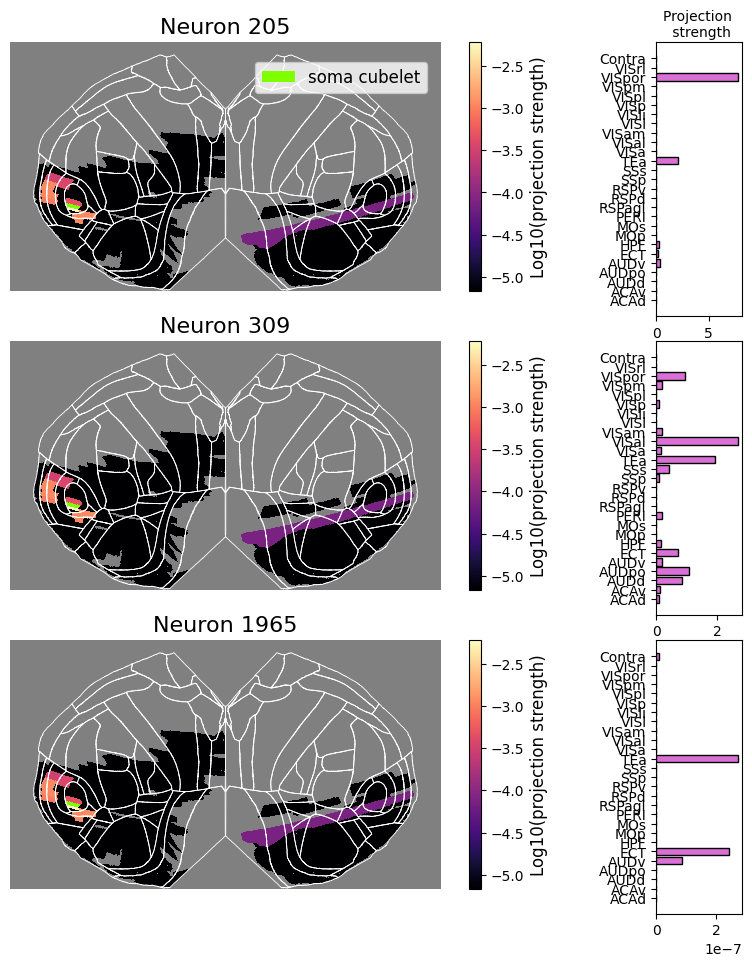

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(9, 11))  # Create subplots
axes = axes.ravel()  # Flatten axes for easy iteration

# Define the vertical positions for even spacing
vertical_positions = [0.85, 0.55, 0.25]  # Adjust these values for even spacing
plot_height = 0.25  # Height of each subplot (proportional)

# Loop to create each plot
for idx, (barcode_index, ax) in enumerate(zip([dorsal_ind, all_ind, gen_ind], axes)):
    mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
    if mouse == 'FIAA45.6d':
        adjusted_bc_ind = barcode_index - len(vis_barcodes['FIAA45.6a'] + 1)
    elif mouse == 'FIAA55.4d':
        adjusted_bc_ind = barcode_index - (len(vis_barcodes['FIAA45.6a']) + len(vis_barcodes['FIAA45.6d']) + 1)
    elif mouse == 'FIAA45.6a':
        adjusted_bc_ind = barcode_index

    # Set the position of the current axis for even spacing
    ax.set_position([0.1, vertical_positions[idx], 0.6, plot_height])

    # Create the main plot
    new_fig = ax.imshow(
        masked_data,
        cmap=new_cmap,
        norm=norm,
        interpolation='nearest'
    )
    ax.axis('off')
    ax.set_title(f"Neuron {barcode_index}", fontsize=16, y=1)  # Adjust title position

    # Add a colorbar to the main plot
    cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Log10(projection strength)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Add boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)

    # Add the inset bar plot
    ax_inset = ax.inset_axes([1.5, -0.1, 0.2, 1.1])  # Adjust as needed
    labels = bc_across_area.iloc[adjusted_bc_ind].index.astype(str).tolist()
    values = bc_across_area.iloc[adjusted_bc_ind].values
    y_positions = np.arange(len(labels))
    ax_inset.barh(y_positions, values, color='orchid', edgecolor='black')
    ax_inset.set_yticks(y_positions)
    ax_inset.set_yticklabels(labels)
    if idx == 0:
        ax_inset.set_xlabel("Projection \n strength")
        ax_inset.xaxis.set_label_position('top')  # Label on top
    else:
        ax_inset.set_xlabel("")

# Add legend
chartreuse_patch = Patch(facecolor='chartreuse', edgecolor='none', label='soma cubelet')
fig.legend(handles=[chartreuse_patch], loc='upper right', fontsize=12, bbox_to_anchor=(0.84, 0.88))

plt.show()
